In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import torch
import random
from sklearn.cluster import KMeans

import sys
import os
sys.path.append(os.path.abspath("../.."))
import src.HiddenMarkovOT as HiddenMarkovOT
import src.utils.clustering as clustering
import src.plotting as plotting


from itertools import product
from sklearn.cluster import KMeans
import torch
import numpy as np
import pandas as pd
import src.validation.trajectory_validation as tv
import src.utils.util_LR as util_LR
import src.utils.waddington.simulation as simu

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return
    
GLOBAL_SEED = 42
seed_everything(GLOBAL_SEED)

In [14]:
# fixed noise level
D = 0.01
snap_times = [0, 200, 399]

# run the Langevin simulator
sim = simu.simulate_langevin_tristable(
    D,
    num_traj=300,
    N_steps=400,
    dt=0.02,
    snap_times=tuple(snap_times),
    seed=GLOBAL_SEED,
    plot_original=False    # turn off extra plotting
)

# collect snapshots into a list
Ss = [ sim['snapshots'][t] for t in snap_times ]
data_snap = {f"step_{t}": sim['snapshots'][t] for t in snap_times}

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype    = torch.float32
dtype_np = np.float32
K=3


=== λ=1.00e+02, eps_df=1.00e-06 ===


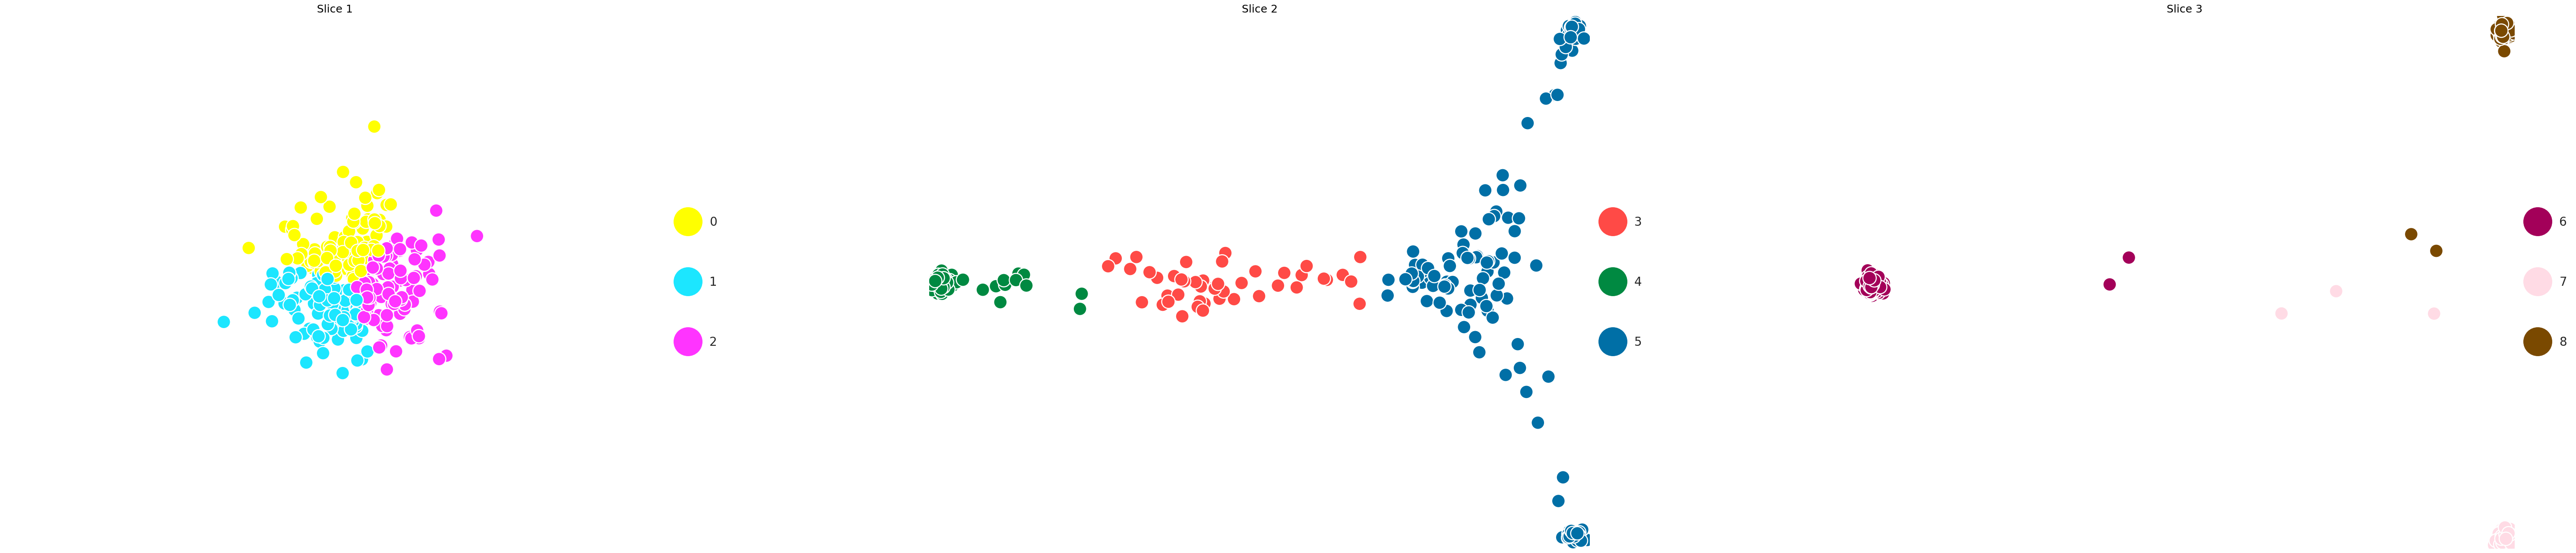

In [ ]:
import importlib
importlib.reload(tv)

# --------------------------- PARAM LISTS --------------------------------------
GWOT_lambda_reg_list = [10**i for i in range(2,6)]       
GWOT_eps_df_list     = [10**i for i in range(-6,-1)]        
# ------------------------------------------------------------------------------


def setup_gwot_grid_search(
    GWOT_lambda_reg_list,
    GWOT_eps_df_list,
    data_snap,
    snap_times,
    device,
    dtype,
    dtype_np,
    K,
    D,
    GLOBAL_SEED,
):
    """
    Grid-search over (lamda_reg, eps_df) for gWOT, evaluating
    latent-trajectory accuracy via analyze_gwOT_only.
    Returns a DataFrame with one row per (lamda_reg, eps_df).
    """
    rows = []
    for lamda_reg, eps_df in product(GWOT_lambda_reg_list, GWOT_eps_df_list):
        print(f"\n=== λ={lamda_reg:.2e}, eps_df={eps_df:.2e} ===")
        frac = tv.analyze_gwot_only(
            data_snap = data_snap,
            snap_times = snap_times,
            lamda_reg = lamda_reg,
            eps_df    = eps_df,
            device    = device,
            dtype     = dtype,
            dtype_np  = dtype_np,
            K         = K,
            D         = D,
            seed      = GLOBAL_SEED,
        )
        rows.append({
            "lambda_reg": lamda_reg,
            "eps_df":      eps_df,
            "frac_gwot":   frac,
        })

    return pd.DataFrame(rows)

# Run
results_df = setup_gwot_grid_search(
    GWOT_lambda_reg_list,
    GWOT_eps_df_list,
    data_snap,
    snap_times,
    device,
    dtype,
    dtype_np,
    K,
    D,
    GLOBAL_SEED,
)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------
def pivot_metric(df, metric):
    """Return a pivoted matrix with λ as rows, ε as cols."""
    return (df
            .pivot(index='lambda_reg', columns='eps_df', values=metric)
            .sort_index(axis=0)   # sort λ
            .sort_index(axis=1))  # sort ε

def annotate_max(ax, data, star_size=18):
    """Place a star on the maximum entry in the heatmap 'data'."""
    i_max, j_max = np.unravel_index(np.nanargmax(data.values), data.shape)
    ax.text(j_max, i_max, "★", ha='center', va='center',
            fontsize=star_size, color='white')

def plot_heatmap_max(df, metric, title, annot_size=8, star_size=18):
    """
    Plot a heatmap of `metric` from `df`, 
    then annotate the cell with the maximum value.
    """
    mat = pivot_metric(df, metric)
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(
        mat, annot=True, fmt=".3g",
        annot_kws={"size": annot_size},
        cbar_kws={'label': metric},
        ax=ax
    )
    annotate_max(ax, mat, star_size=star_size)
    ax.set_title(title)
    ax.set_xlabel("eps_df")
    ax.set_ylabel("lambda_reg")
    plt.tight_layout()
    return fig, ax

# -----------------------------------------------------------------------------
# Usage on results_df
# -----------------------------------------------------------------------------
fig, ax = plot_heatmap_max(
    results_df,
    metric="frac_gwot",
    title="gWOT Fraction‐Correct @ D=0.01",
    annot_size=10,
    star_size=20
)
plt.show()